<a href="https://colab.research.google.com/github/victorjusa/Quantum_algorithms/blob/main/Algoritmo_Grover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritmo de Grover

##Librerias e imports

In [ ]:
!pip install qiskit
!pip install setuptools
!pip install qiskit-ibm-runtime
!pip install qiskit-machine-learning
!pip install "requests~=2.27"
!pip install matplotlib
!pip install qiskit_ibm_provider
!pip install pip install pylatexenc
!pip install qiskit_aer

In [ ]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, Diagonal
# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import qiskit
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister

from qiskit_ibm_provider import least_busy
# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService,Session ,Batch,Session, Sampler
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler
import numpy as np
import math
from fractions import Fraction
import time
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt



##Construyendo el circuito

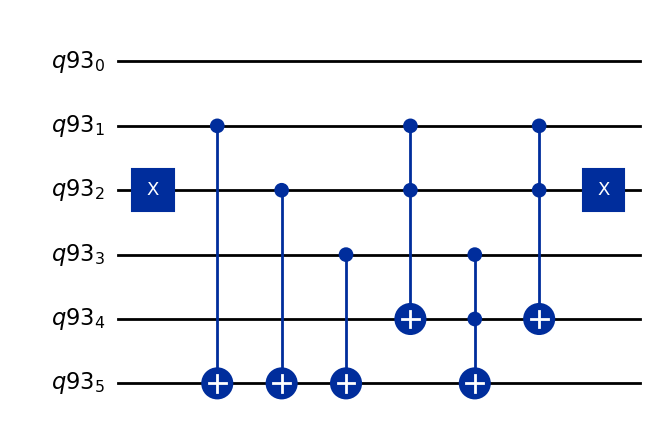

In [ ]:
q = QuantumRegister(6)
qc = QuantumCircuit(q)
qc.x(q[2])
qc.cx(q[1], q[5])
qc.cx(q[2], q[5])
qc.cx(q[3], q[5])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[3], q[4], q[5])
qc.ccx(q[1], q[2], q[4])
qc.x(q[2])
qc.draw(output='mpl')

In [ ]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
 # -- end function


In [ ]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

In [ ]:
def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

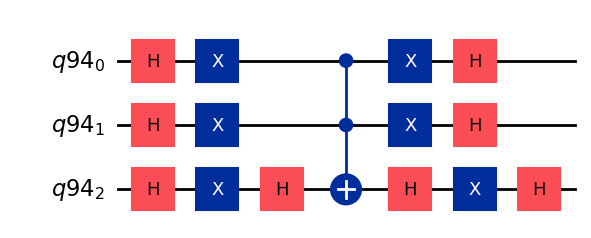

In [ ]:
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_average(qInvAvg, qr, 3)
qInvAvg.draw(output='mpl')

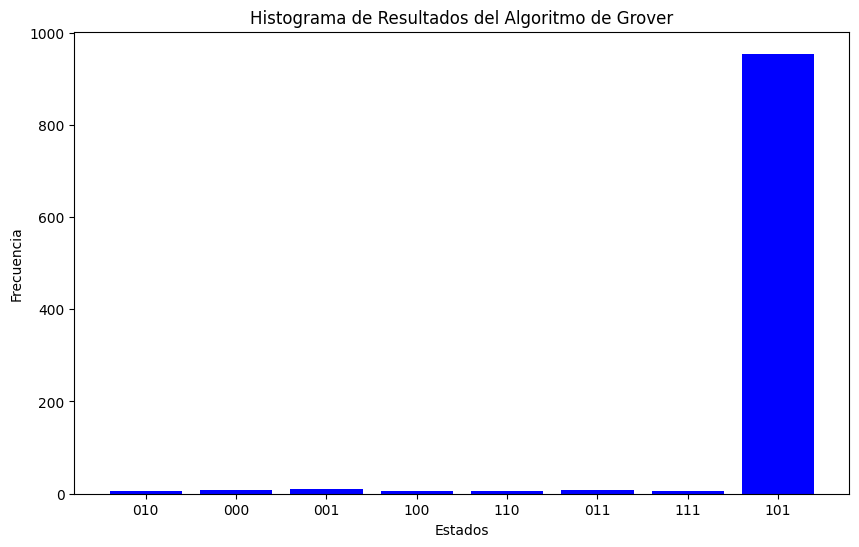

In [ ]:
"""
Grover search implemented in Qiskit.

This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684.
"""

def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# Make a quantum program for the n-bit Grover search.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Define quantum circuit with above registers
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

input_state(grover, f_in, f_out, n)
T = 2
for t in range(T):
    # Apply T full iterations
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

# Execute circuit

# Ejecutar el circuito
simulator = AerSimulator()
compiled_grover = transpile(grover, simulator)
job = simulator.run(compiled_grover, shots=1000)
result = job.result()




# Obtener cuentas y trazar histograma
counts = result.get_counts(compiled_grover)
# Obtener los estados y sus frecuencias
states = list(counts.keys())
frequencies = list(counts.values())

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(states, frequencies, color='blue')

# Añadir títulos y etiquetas
plt.xlabel('Estados')
plt.ylabel('Frecuencia')
plt.title('Histograma de Resultados del Algoritmo de Grover')

# Mostrar el gráfico
plt.show()

In [ ]:

QiskitRuntimeService.save_account(channel="ibm_quantum", token='a53e5379fb809070499f1c93bc3e4c8f0f0d79ce82208e955f66a2c31c7a8e94dd89d9cbc9949876ae3df523d355ede6e607911af787b5049bbd56867feb8c2b', overwrite=True)
provider = QiskitRuntimeService()

# Filtrar para ver aquellos que solo tienen más de x qubits
small_devices = provider.backends(min_num_qubits=5, simulator=False, operational=True)

# Elegir el servidor que esté menos ocupado
backend = least_busy(small_devices)

print(f"Elegido backend: {backend}")

# Establecemos nuestro backend
backend = provider.get_backend('ibm_brisbane')

Elegido backend: <IBMBackend('ibm_sherbrooke')>


<ipython-input-63-455657974579>:13: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = provider.get_backend('ibm_brisbane')


In [ ]:
# compilamos el circuito usando ibm_brisbane
grover_compiled = transpile(grover, backend=backend, seed_transpiler=1, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  OrderedDict([('rz', 2376), ('sx', 1417), ('ecr', 707), ('x', 116), ('measure', 3)])
depth =  2517


In [ ]:
# Ejecutar el circuito en el backend
job = backend.run(grover_compiled, shots=1024)

# Monitorear el trabajo manualmente
while job.status().name != 'DONE':
    print(f"Job status: {job.status().name}")
    time.sleep(60)  # Esperar 10 segundos antes de verificar el estado nuevamente

# Obtener los resultados
result = job.result()

# Obtener las cuentas y mostrar el histograma
counts = result.get_counts(grover_compiled)
print(counts)
plot_histogram(counts)
plt.show()

<ipython-input-69-621e435bb447>:2: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(grover_compiled, shots=1024)


Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
Job status: QUEUED
{'001': 147, '100': 117, '011': 153, '010': 118, '101': 139, '110': 127, '000': 104, '111': 119}


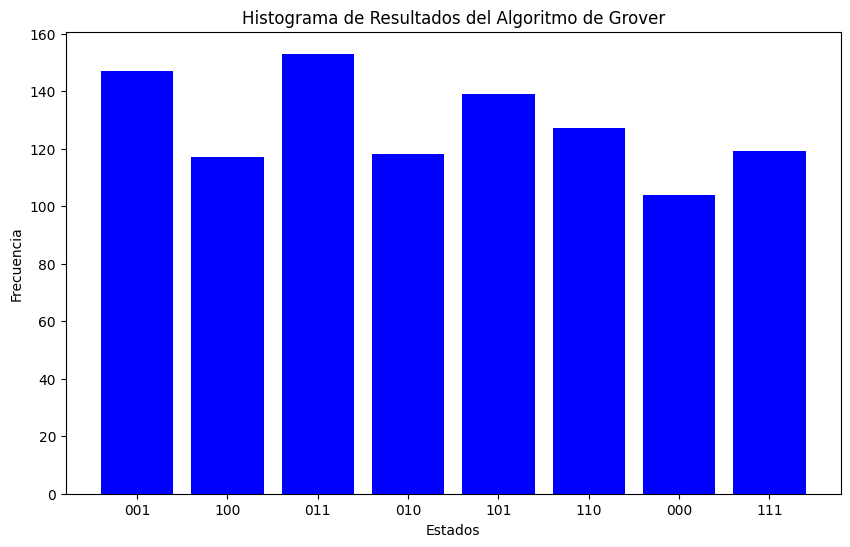

In [ ]:
# Obtener cuentas y trazar histograma
counts = result.get_counts(compiled_grover)
# Obtener los estados y sus frecuencias
states = list(counts.keys())
frequencies = list(counts.values())

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(states, frequencies, color='blue')

# Añadir títulos y etiquetas
plt.xlabel('Estados')
plt.ylabel('Frecuencia')
plt.title('Histograma de Resultados del Algoritmo de Grover')

# Mostrar el gráfico
plt.show()